In [1]:
%matplotlib inline
import torch
import torchvision
import json
import cv2
import numpy as np
import os

from matplotlib import pyplot as plt

from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter 
from torchvision import transforms, utils
from torchsummary import summary

from Data_Loader import Pose_Dataset, my_collate, RandomFlip, RandomRotate, ToTensor
from model import VRUNet
from Modify_annotations import scale_annotations

In [2]:
# set parameters here before training

# fraction of validation dataset, default = 5%
# val_fraction = 0.05 

# train, val batch size
train_batch_size = 8
val_batch_size = 16

# use multiple GPUs if available, default = True
multi_GPU = True

# number of epochs
num_epochs = 20

# annotations and image path
annotations_path = 'Data/COCO/annotations/person_keypoints_train2017.json'
img_path = 'Data/COCO/train2017/'

val_annotations_path = 'Data/COCO/annotations/person_keypoints_val2017.json'
val_img_path = 'Data/COCO/val2017/'

# don't modify this
# scaled_annotations_path = annotations_path[:-5] + '_copy.json'

In [3]:
# scale_annotations(annotations_path, scaled_annotations_path)

In [4]:
torch.cuda.empty_cache()

In [5]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [6]:
train_dataset = Pose_Dataset(annotations_path = annotations_path,
                      img_path = img_path,
                      transform = transforms.Compose([
                          RandomFlip(0.5),
                          RandomRotate(degree = 10),
                          ToTensor()
                      ]),
                       dataset = 'COCO'
                      )
val_dataset = Pose_Dataset(annotations_path = val_annotations_path,
                           img_path = val_img_path,
                           transform = transforms.Compose([
                               RandomFlip(0.5),
                               RandomRotate(degree = 10),
                               ToTensor()
                           ]),
                           dataset = 'COCO'
                          )

print("No. of images in training set :",len(train_dataset))
print("No. of images in validation set :",len(val_dataset))

# train_dataset, val_dataset = torch.utils.data.random_split(dataset, [len_train_images, len_val_images]) 

train_dataloader = DataLoader(train_dataset, batch_size = train_batch_size, shuffle = False, collate_fn = my_collate)
val_dataloader = DataLoader(val_dataset, batch_size = val_batch_size, shuffle = False, collate_fn = my_collate)

No. of images in training set : 262465
No. of images in validation set : 11004


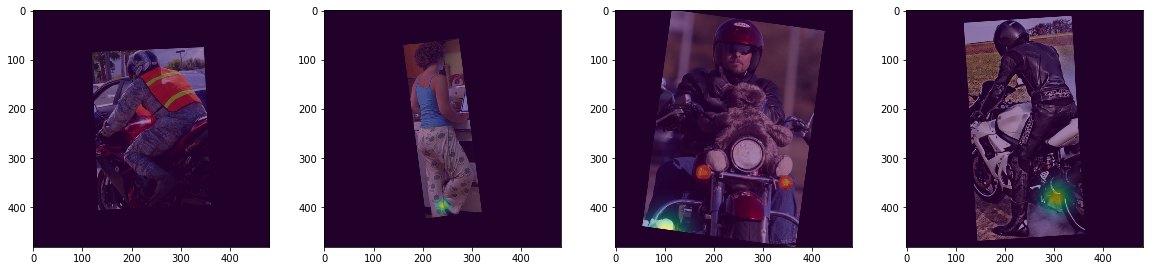

In [7]:
# visualize batch of images from dataloader
iterator = iter(train_dataloader)
images, target = next(iterator)
# images, target = next(iterator)
fig = plt.figure(figsize = (20,20))
axes = []
for i in range(images.shape[0]):
    img = np.transpose(images[i].cpu(), (1,2,0))
    axes.append(fig.add_subplot(4, 4, i+1))
    plt.imshow(img[:, :, [2, 1, 0]])
    plt.imshow(target[i][16].cpu(), alpha = 0.5)
plt.show()

In [8]:
model = VRUNet()
if torch.cuda.device_count() > 1 and multi_GPU:
    print("Using ",torch.cuda.device_count(), " GPUs for training!!")
    model = nn.DataParallel(model)

model.to(device)

VRUNet(
  (Backbone): BackBone(
    (bb1): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 16, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
        (batchnorm): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU()
      )
      (1): Conv(
        (conv): Conv2d(16, 16, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
        (batchnorm): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU()
      )
      (2): Conv(
        (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (batchnorm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU()
      )
      (3): Conv(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (batchnorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU()
      )
    )
    (bb2): Seque

In [9]:
# Setting up tensorboard
writer = SummaryWriter('runs/VRU_Net_experiment1')
dataiter = iter(train_dataloader)
images, targets = dataiter.next()
img_grid = torchvision.utils.make_grid(images)
writer.add_image('train_loader image batch', img_grid)

In [10]:
writer.add_graph(model, images)
writer.close()

C:\Users\Kartikaeya\Anaconda3\lib\site-packages\torch\nn\functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 4.00 GiB total capacity; 2.80 GiB already allocated; 1.27 MiB free; 2.93 GiB reserved in total by PyTorch)
Error occurs, No graph saved


RuntimeError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 4.00 GiB total capacity; 2.80 GiB already allocated; 1.27 MiB free; 2.93 GiB reserved in total by PyTorch)

In [ ]:
torch.cuda.empty_cache()

In [23]:
#train the neural network finally
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
loss_func = torch.nn.MSELoss(reduction = 'sum')

i = 0
prev_epoch = 0
for epoch in range(num_epochs):
    model.train()
    prev_epoch += i
    i = 0
    for images, target in train_dataloader:
        i += 1
        if(images.shape[0] == 0 or images.shape[2] > 550 or images.shape[3] > 550):
            i -= 1
            continue
        print("batch number : ",i, "epoch : ", epoch, " tensor size = ", images.shape, "memory usage = ", torch.cuda.memory_allocated())
        optimizer.zero_grad()
        pred = model(images)
#         loss = 25*loss_func(pred[:, 0:17], target[:, 0:17]) + 150*loss_func(pred[:, 17:34], target[:, 17:34]) + 500*loss_func(pred[:, 34:51], target[:, 34:51]) +  1000*loss_func(pred[:, 51:68], target[:, 51:68])
        loss = (loss_func(pred, target*((images.shape[2]*images.shape[3]) / 6400)))
        loss.backward()
        optimizer.step()
        
        writer.add_scalar('train_loss', loss.item(), prev_epoch + i)
#         running_train_loss += loss.cpu().detach().item()
        
        del pred, images, target, loss
        
        
        # write train, val losses to tensorboard
        if i%1000 == 999:
            

            model.eval()
            with torch.no_grad():
                k = 0
                valid_loss = 0
                for img, trgt in val_dataloader:
                    if(k > 100):
                        break
                    if(img.shape[0] == 0):
                        continue
                    print("val batch number : ",k, " tensor size = ", img.shape, "memory usage = ", torch.cuda.memory_allocated())
                    valid_loss += loss_func(model(img), trgt)* ((img.shape[2]*img.shape[3]) / 6400)
                    k += 1
                    
            writer.add_scalar('val_loss', valid_loss/k,  prev_epoch + i)
            model.train()

batch number :  1 epoch :  0  tensor size =  torch.Size([1, 3, 324, 235]) memory usage =  152963072
batch number :  2 epoch :  0  tensor size =  torch.Size([1, 3, 365, 150]) memory usage =  466898944
batch number :  3 epoch :  0  tensor size =  torch.Size([1, 3, 465, 347]) memory usage =  496993280
batch number :  4 epoch :  0  tensor size =  torch.Size([1, 3, 448, 231]) memory usage =  480559104
batch number :  5 epoch :  0  tensor size =  torch.Size([1, 3, 200, 107]) memory usage =  457246208
batch number :  6 epoch :  0  tensor size =  torch.Size([1, 3, 170, 106]) memory usage =  456286720
batch number :  7 epoch :  0  tensor size =  torch.Size([1, 3, 224, 78]) memory usage =  456130560
batch number :  8 epoch :  0  tensor size =  torch.Size([1, 3, 173, 287]) memory usage =  465269760
batch number :  9 epoch :  0  tensor size =  torch.Size([1, 3, 373, 317]) memory usage =  484749312
batch number :  10 epoch :  0  tensor size =  torch.Size([1, 3, 408, 289]) memory usage =  484655616


batch number :  162 epoch :  0  tensor size =  torch.Size([1, 3, 297, 97]) memory usage =  459350528
batch number :  163 epoch :  0  tensor size =  torch.Size([1, 3, 134, 100]) memory usage =  454974464
batch number :  164 epoch :  0  tensor size =  torch.Size([1, 3, 501, 254]) memory usage =  487308800
batch number :  165 epoch :  0  tensor size =  torch.Size([1, 3, 148, 79]) memory usage =  454489600
batch number :  166 epoch :  0  tensor size =  torch.Size([1, 3, 168, 142]) memory usage =  457944064
batch number :  167 epoch :  0  tensor size =  torch.Size([1, 3, 411, 269]) memory usage =  482567680
batch number :  168 epoch :  0  tensor size =  torch.Size([1, 3, 296, 405]) memory usage =  485214720
batch number :  169 epoch :  0  tensor size =  torch.Size([1, 3, 323, 146]) memory usage =  464561664
batch number :  170 epoch :  0  tensor size =  torch.Size([1, 3, 395, 289]) memory usage =  483588608
batch number :  171 epoch :  0  tensor size =  torch.Size([1, 3, 158, 92]) memory us

batch number :  322 epoch :  0  tensor size =  torch.Size([1, 3, 245, 121]) memory usage =  459587584
batch number :  323 epoch :  0  tensor size =  torch.Size([1, 3, 451, 234]) memory usage =  481140224
batch number :  324 epoch :  0  tensor size =  torch.Size([1, 3, 223, 263]) memory usage =  467825152
batch number :  325 epoch :  0  tensor size =  torch.Size([1, 3, 153, 117]) memory usage =  456252416
batch number :  326 epoch :  0  tensor size =  torch.Size([1, 3, 138, 85]) memory usage =  454499840
batch number :  327 epoch :  0  tensor size =  torch.Size([1, 3, 484, 248]) memory usage =  485257728
batch number :  328 epoch :  0  tensor size =  torch.Size([1, 3, 535, 501]) memory usage =  527290880
batch number :  329 epoch :  0  tensor size =  torch.Size([1, 3, 320, 142]) memory usage =  464296448
batch number :  330 epoch :  0  tensor size =  torch.Size([1, 3, 149, 76]) memory usage =  454384640
batch number :  331 epoch :  0  tensor size =  torch.Size([1, 3, 159, 112]) memory u

batch number :  482 epoch :  0  tensor size =  torch.Size([1, 3, 257, 169]) memory usage =  464272384
batch number :  483 epoch :  0  tensor size =  torch.Size([1, 3, 154, 89]) memory usage =  455061504
batch number :  484 epoch :  0  tensor size =  torch.Size([1, 3, 134, 98]) memory usage =  454898176
batch number :  485 epoch :  0  tensor size =  torch.Size([1, 3, 174, 210]) memory usage =  461545984
batch number :  486 epoch :  0  tensor size =  torch.Size([1, 3, 411, 186]) memory usage =  473057280
batch number :  487 epoch :  0  tensor size =  torch.Size([1, 3, 190, 80]) memory usage =  455485440
batch number :  488 epoch :  0  tensor size =  torch.Size([1, 3, 184, 74]) memory usage =  455035904
batch number :  489 epoch :  0  tensor size =  torch.Size([1, 3, 201, 78]) memory usage =  455621120
batch number :  490 epoch :  0  tensor size =  torch.Size([1, 3, 361, 162]) memory usage =  467777536
batch number :  491 epoch :  0  tensor size =  torch.Size([1, 3, 119, 103]) memory usag

batch number :  549 epoch :  0  tensor size =  torch.Size([1, 3, 248, 272]) memory usage =  470326272
batch number :  550 epoch :  0  tensor size =  torch.Size([1, 3, 319, 103]) memory usage =  460500992
batch number :  551 epoch :  0  tensor size =  torch.Size([1, 3, 157, 67]) memory usage =  454156800
batch number :  552 epoch :  0  tensor size =  torch.Size([1, 3, 302, 68]) memory usage =  457001472
batch number :  553 epoch :  0  tensor size =  torch.Size([1, 3, 305, 77]) memory usage =  457839104
batch number :  554 epoch :  0  tensor size =  torch.Size([1, 3, 185, 78]) memory usage =  455267328
batch number :  555 epoch :  0  tensor size =  torch.Size([1, 3, 277, 121]) memory usage =  460687872
batch number :  556 epoch :  0  tensor size =  torch.Size([1, 3, 316, 172]) memory usage =  466894336
batch number :  557 epoch :  0  tensor size =  torch.Size([1, 3, 318, 140]) memory usage =  463813120
batch number :  558 epoch :  0  tensor size =  torch.Size([1, 3, 297, 113]) memory usa

batch number :  709 epoch :  0  tensor size =  torch.Size([1, 3, 358, 244]) memory usage =  475977216
batch number :  710 epoch :  0  tensor size =  torch.Size([1, 3, 450, 263]) memory usage =  484780544
batch number :  711 epoch :  0  tensor size =  torch.Size([1, 3, 304, 107]) memory usage =  460407296
batch number :  712 epoch :  0  tensor size =  torch.Size([1, 3, 213, 76]) memory usage =  455766528
batch number :  713 epoch :  0  tensor size =  torch.Size([1, 3, 277, 118]) memory usage =  460452352
batch number :  714 epoch :  0  tensor size =  torch.Size([1, 3, 252, 200]) memory usage =  466454016
batch number :  715 epoch :  0  tensor size =  torch.Size([1, 3, 284, 125]) memory usage =  461251584
batch number :  716 epoch :  0  tensor size =  torch.Size([1, 3, 276, 359]) memory usage =  479309312
batch number :  717 epoch :  0  tensor size =  torch.Size([1, 3, 186, 116]) memory usage =  457296896
batch number :  718 epoch :  0  tensor size =  torch.Size([1, 3, 313, 191]) memory 

batch number :  869 epoch :  0  tensor size =  torch.Size([1, 3, 262, 157]) memory usage =  462851584
batch number :  870 epoch :  0  tensor size =  torch.Size([1, 3, 268, 144]) memory usage =  462129152
batch number :  871 epoch :  0  tensor size =  torch.Size([1, 3, 124, 115]) memory usage =  455219200
batch number :  872 epoch :  0  tensor size =  torch.Size([1, 3, 216, 158]) memory usage =  460861440
batch number :  873 epoch :  0  tensor size =  torch.Size([1, 3, 254, 150]) memory usage =  461989376
batch number :  874 epoch :  0  tensor size =  torch.Size([1, 3, 243, 114]) memory usage =  459036672
batch number :  875 epoch :  0  tensor size =  torch.Size([1, 3, 477, 262]) memory usage =  486662144
batch number :  876 epoch :  0  tensor size =  torch.Size([1, 3, 231, 184]) memory usage =  463240704
batch number :  877 epoch :  0  tensor size =  torch.Size([1, 3, 142, 122]) memory usage =  456089600
batch number :  878 epoch :  0  tensor size =  torch.Size([1, 3, 273, 144]) memory

KeyboardInterrupt: 

In [13]:
torch.save(model.state_dict(), "trained_models/first_model_3.pth")
print("finished training!!")

finished training!!
